In [34]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [35]:
general_data = pd.read_csv('data/application_record.csv')
credit_data = pd.read_csv('data/credit_record.csv')

credit_agg = credit_data.groupby('ID').agg(
    n_months_onbook=('STATUS', 'count'),
    n_paid_off=('STATUS', lambda s: (s == 'C').sum()),
    n_no_loan=('STATUS', lambda s: (s == 'X').sum()),
    n_overdue_1_29=('STATUS', lambda s: (s == '0').sum()),
    n_overdue_30_59=('STATUS', lambda s: (s == '1').sum()),
    n_overdue_60_89=('STATUS', lambda s: (s == '2').sum()),
    n_overdue_90_119=('STATUS', lambda s: (s == '3').sum()),
    n_overdue_120_149=('STATUS', lambda s: (s == '4').sum()),
    n_overdue_150_plus=('STATUS', lambda s: (s == '5').sum()),
).reset_index()

credit_cals = ['n_months_onbook', 'n_paid_off', 'n_no_loan', 'n_overdue_1_29', 'n_overdue_30_59', 'n_overdue_60_89', 'n_overdue_90_119', 'n_overdue_120_149', 'n_overdue_150_plus']

merged_df = pd.merge(general_data, credit_agg, on='ID', how='left')
merged_df[credit_cals] = merged_df[credit_cals].fillna(0).astype(int)

merged_df['OCCUPATION_TYPE'] = merged_df['OCCUPATION_TYPE'].fillna('NOT_SPECIFIED')

binary_maps = {
    'CODE_GENDER':     {'M': 0, 'F': 1},
    'FLAG_OWN_CAR':    {'N': 0, 'Y': 1},
    'FLAG_OWN_REALTY': {'N': 0, 'Y': 1},
}
for col, mapping in binary_maps.items():
    merged_df[col] = merged_df[col].map(mapping)

label_cols = [
    'NAME_INCOME_TYPE', 
    'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE', 
    'OCCUPATION_TYPE'
]
for col in label_cols:
    merged_df[col] = LabelEncoder().fit_transform(merged_df[col])

def weighted_risk(group, decay=0.05):
    def to_severity(x):
        mapping = {
            '0': 0,
            '1': 1,
            '2': 4,
            '3': 9,
            '4': 16,
            '5': 25,
        }
        return mapping.get(x, 0)

    severity = group['STATUS'].map(to_severity)
    weights = np.exp(decay * group['MONTHS_BALANCE'])

    num = np.sum(severity * weights)
    den = np.sum(weights)
    
    if den == 0:
        return 0.0

    return num / den

weighted_risk_series = (
    credit_data
    .groupby('ID')[['STATUS', 'MONTHS_BALANCE']]
    .apply(weighted_risk)
    .rename('weighted_risk_score')
    .reset_index()
)

merged_df = merged_df.merge(weighted_risk_series, on='ID')

def to_risk_status(score):
    if score == 0:
        return 0; # approved
    elif score < 0.1:
        return 1; # manual review
    elif score < 0.5:
        return 2; # decline
    else:
        return 3; # blacklist


merged_df['risk_status'] = merged_df['weighted_risk_score'].apply(to_risk_status)

merged_df.drop(columns=['ID'])

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,...,n_paid_off,n_no_loan,n_overdue_1_29,n_overdue_30_59,n_overdue_60_89,n_overdue_90_119,n_overdue_120_149,n_overdue_150_plus,weighted_risk_score,risk_status
0,0,1,1,0,427500.0,4,1,0,4,-12005,...,13,1,1,1,0,0,0,0,0.046235,1
1,0,1,1,0,427500.0,4,1,0,4,-12005,...,12,1,1,1,0,0,0,0,0.050728,1
2,0,1,1,0,112500.0,4,4,1,1,-21474,...,7,16,7,0,0,0,0,0,0.000000,0
3,1,0,1,0,270000.0,0,4,3,1,-19110,...,0,3,2,0,0,0,0,0,0.000000,0
4,1,0,1,0,270000.0,0,4,3,1,-19110,...,0,5,0,0,0,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,0,1,1,0,315000.0,4,4,1,1,-17348,...,0,8,0,0,0,0,1,3,9.064998,3
36453,1,0,1,0,157500.0,0,1,1,1,-12387,...,5,0,1,7,2,1,1,7,9.629062,3
36454,1,0,1,0,157500.0,1,1,1,1,-12387,...,14,0,1,7,2,1,1,7,5.310353,3
36455,1,0,1,0,283500.0,4,4,1,1,-17958,...,0,0,8,1,1,0,0,0,0.613706,3


In [36]:
print(merged_df.shape)
display(merged_df.head())
merged_df.info()
print(merged_df.dtypes)
missing_count = merged_df.isna().sum()
missing_share = merged_df.isna().mean()
display(pd.DataFrame({"missing_count": missing_count, "missing_share": missing_share}))
display(merged_df.describe(include="all"))

category_cols = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
]

for col in category_cols:
    n_unique = merged_df[col].nunique(dropna=True)
    print(f"{col}: {n_unique} options")
    print(f"    {merged_df[col].unique()}")

merged_df['weighted_risk_score'].describe()
merged_df['weighted_risk_score'].quantile([0.5,0.8,0.9,0.95,0.99])

pct = (merged_df['risk_status'].value_counts(normalize=True) * 100).round(2)

print(pct)

(36457, 29)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,n_paid_off,n_no_loan,n_overdue_1_29,n_overdue_30_59,n_overdue_60_89,n_overdue_90_119,n_overdue_120_149,n_overdue_150_plus,weighted_risk_score,risk_status
0,5008804,0,1,1,0,427500.0,4,1,0,4,...,13,1,1,1,0,0,0,0,0.046235,1
1,5008805,0,1,1,0,427500.0,4,1,0,4,...,12,1,1,1,0,0,0,0,0.050728,1
2,5008806,0,1,1,0,112500.0,4,4,1,1,...,7,16,7,0,0,0,0,0,0.000000,0
3,5008808,1,0,1,0,270000.0,0,4,3,1,...,0,3,2,0,0,0,0,0,0.000000,0
4,5008809,1,0,1,0,270000.0,0,4,3,1,...,0,5,0,0,0,0,0,0,0.000000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  int64  
 2   FLAG_OWN_CAR         36457 non-null  int64  
 3   FLAG_OWN_REALTY      36457 non-null  int64  
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  int64  
 7   NAME_EDUCATION_TYPE  36457 non-null  int64  
 8   NAME_FAMILY_STATUS   36457 non-null  int64  
 9   NAME_HOUSING_TYPE    36457 non-null  int64  
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

,missing_count,missing_share
ID,0,0.0
CODE_GENDER,0,0.0
FLAG_OWN_CAR,0,0.0
FLAG_OWN_REALTY,0,0.0
CNT_CHILDREN,0,0.0
AMT_INCOME_TOTAL,0,0.0
NAME_INCOME_TYPE,0,0.0
NAME_EDUCATION_TYPE,0,0.0
NAME_FAMILY_STATUS,0,0.0
NAME_HOUSING_TYPE,0,0.0


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,n_paid_off,n_no_loan,n_overdue_1_29,n_overdue_30_59,n_overdue_60_89,n_overdue_90_119,n_overdue_120_149,n_overdue_150_plus,weighted_risk_score,risk_status
count,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,...,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.670105,0.379708,0.672189,0.430315,1.866857e+05,2.398195,3.097183,1.367885,1.282881,...,9.039032,4.003346,7.972516,0.239926,0.021971,0.007845,0.005870,0.041885,0.058180,0.178183
std,4.187524e+04,0.470181,0.485321,0.469422,0.742367,1.017892e+05,1.734032,1.341292,0.954557,0.951675,...,13.026453,8.667466,7.748513,0.947265,0.209588,0.100982,0.093212,0.895565,0.774408,0.536176
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.042028e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.074614e+06,1.000000,0.000000,1.000000,0.000000,1.575000e+05,4.000000,4.000000,1.000000,1.000000,...,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.115396e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,4.000000,4.000000,1.000000,1.000000,...,15.000000,3.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.150487e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,4.000000,4.000000,4.000000,5.000000,...,59.000000,61.000000,60.000000,27.000000,8.000000,4.000000,7.000000,48.000000,24.219551,3.000000


CODE_GENDER: 2 options
    [0 1]
FLAG_OWN_CAR: 2 options
    [1 0]
FLAG_OWN_REALTY: 2 options
    [1 0]
NAME_INCOME_TYPE: 5 options
    [4 0 1 2 3]
NAME_EDUCATION_TYPE: 5 options
    [1 4 2 3 0]
NAME_FAMILY_STATUS: 5 options
    [0 1 3 2 4]
NAME_HOUSING_TYPE: 6 options
    [4 1 2 5 0 3]
OCCUPATION_TYPE: 19 options
    [12 17 15  0  8 10  4  3  6  1 13  2  9 11 16 18  5 14  7]
risk_status
0    88.23
1     6.73
2     4.04
3     1.00
Name: proportion, dtype: float64


Best parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 8}


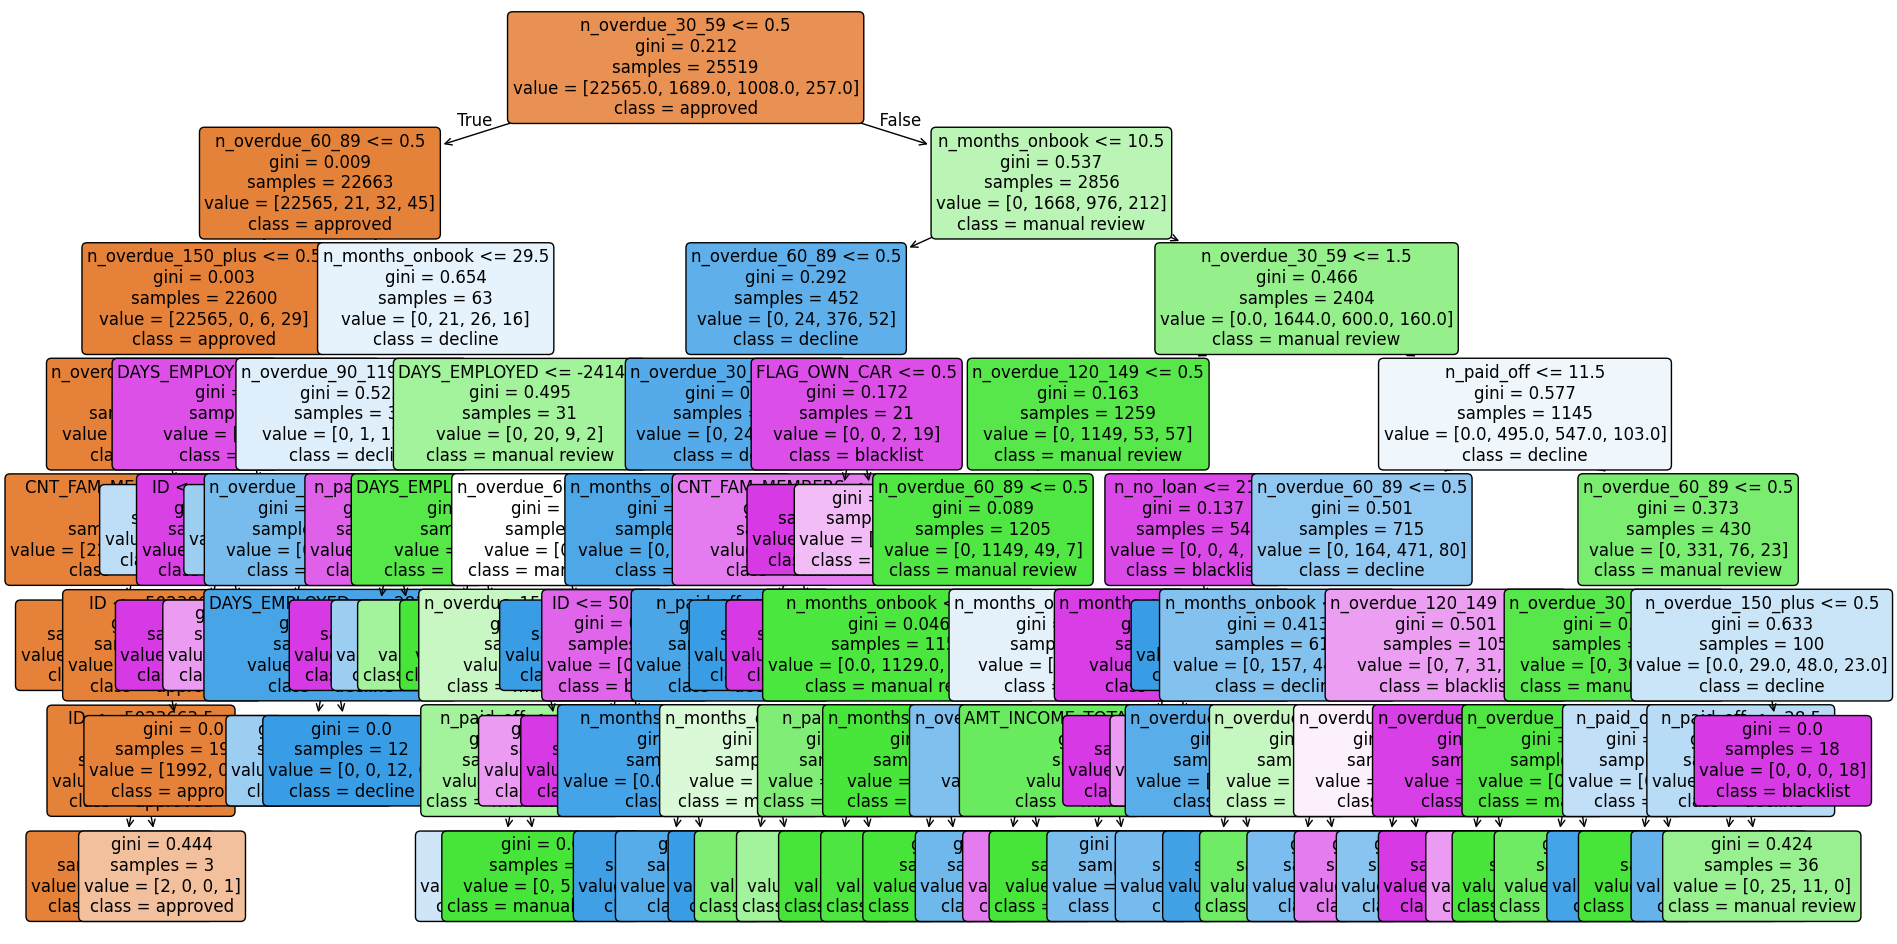

In [40]:
# Decision tree
features = [col for col in merged_df.columns if col not in ['risk_status', 'weighted_risk_score']]
X = merged_df.drop(columns=['risk_status', 'weighted_risk_score'])
y = merged_df['risk_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

plt.figure(figsize=(22,12))
plot_tree(best_model, feature_names=features, class_names=['approved', 'manual review', 'decline', 'blacklist'],
          filled=True, rounded=True, fontsize=12)
plt.show()

In [41]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9601
           1       0.94      0.92      0.93       763
           2       0.84      0.88      0.86       465
           3       0.81      0.76      0.78       109

    accuracy                           0.99     10938
   macro avg       0.90      0.89      0.89     10938
weighted avg       0.99      0.99      0.99     10938



In [42]:
importances = best_model.feature_importances_
sorted(zip(features, importances), key=lambda x: x[1], reverse=True)[:20]

[('n_overdue_30_59', np.float64(0.7945155748577886)),
 ('n_months_onbook', np.float64(0.0761113449142693)),
 ('n_overdue_60_89', np.float64(0.047050441220116666)),
 ('n_paid_off', np.float64(0.03622618238256426)),
 ('n_overdue_120_149', np.float64(0.01992864614385544)),
 ('n_overdue_150_plus', np.float64(0.014773684432216815)),
 ('n_overdue_90_119', np.float64(0.003243384241704204)),
 ('n_overdue_1_29', np.float64(0.002949299697599591)),
 ('CNT_FAM_MEMBERS', np.float64(0.0014858111348487058)),
 ('DAYS_EMPLOYED', np.float64(0.0011907129123851026)),
 ('n_no_loan', np.float64(0.0010789031149092511)),
 ('AMT_INCOME_TOTAL', np.float64(0.0007037287527931768)),
 ('ID', np.float64(0.0005008091823501834)),
 ('FLAG_OWN_CAR', np.float64(0.00024147701259866046)),
 ('CODE_GENDER', np.float64(0.0)),
 ('FLAG_OWN_REALTY', np.float64(0.0)),
 ('CNT_CHILDREN', np.float64(0.0)),
 ('NAME_INCOME_TYPE', np.float64(0.0)),
 ('NAME_EDUCATION_TYPE', np.float64(0.0)),
 ('NAME_FAMILY_STATUS', np.float64(0.0))]